<a id="title_ID"></a>
# Beginner: Read and Plot A TESS Light Curve File

This notebook tutorial demonstrates how to load and plot the contents of a TESS light curve (lc) file.  We will plot the flux timeseries contained within the file, and display which pixels were used in the photometric aperture.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Introduction

A light curve is a plot of flux versus time, and is used to identify variability, including the transits of orbiting companions like planets.  The light curve shown here will be for the star TIC 25155310, which is known to host at least one planet, WASP-126 b.

This tutorial will refer to a couple TESS-related terms that we define here.
* Sector = TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres.  Each of these regions is referred to as a "sector", starting with Sector 1.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* TBJD = TESS Barycentric Julian Date, the timestamp measured in BJD, but offset by 2457000.0.  I.e., TBJD = BJD - 2457000.0
* SAP Flux = Simple Aperture Photometry flux, the flux after summing the calibrated pixels within the TESS optimal photometric aperture.
* PDCSAP Flux = Pre-search Data Conditioned Simple Aperture Photometry, the SAP flux values nominally corrected for instrumental variations.  Thus, these fluxes are the mission's best estimate of the intrinsic variability of the target.

## Obtaining The Light Curve File

We will read the light curve file from Sector 1 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve TESS files, we won't show how to search and retrieve TESS light curve files in this tutorial.  Consult other TESS tutorials [in the TESS Archive Handbook](https://outerspace.stsci.edu/display/TESS/6.0+-+Data+Search+Tutorials) for much more information on how to search for TESS data using MAST services.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
fits_file = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0000/2515/5310/tess2018206045859-s0001-0000000025155310-0120-s_lc.fits"

## Understanding The Light Curve FITS File Structure

TESS light curve FITS files contain a primary HDU with metadata stored in the header.  The first extension HDU contains more metadata in the header, and stores arrays of data in a binary FITS table, which include the timestamps, SAP fluxes, and PDCSAP fluxes.  The second extension HDU consists of an image that contains the collected pixels for this target, and records information about them, such as which of those pixels were used in the optimal photometric aperture to create the SAP fluxes.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.

In [3]:
fits.info(fits_file)

Filename: /Users/yuhanyao/.astropy/cache/download/py3/965b2ad4aa34630130f09303aee051a0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Let's examine the binary table in the first FITS extension, since that contains the arrays of timestamps and fluxes we want to plot.  We will use the astropy.fits `getdata` function to access the table from the first extension HDU, and then show the columns of the table.  We can see included in the table are columns for the timestamps in TESS BJD format (**TIME**), SAP flux (**SAP_FLUX**), and PDCSAP flux (**PDCSAP_FLUX**).

In [4]:
fits.getdata(fits_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

## Reading the timestamps and fluxes.

Now that we have the light curve file, let's store the timestamps and fluxes as arrays for use later.

In [7]:
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    sap_fluxes_unc = hdulist[1].data['SAP_FLUX_ERR']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_unc = hdulist[1].data['PDCSAP_FLUX_ERR']

## Plot the light curve.

Let's make a plot of the PDCSAP flux vs. time in TESS BJD.  The orbital period for WASP-126 b is 3.288776 days, and the epoch of primary transit is T0 = 1327.520678 in TBJD.  Let's also plot a vertical line at T0, and zoom in within +/- 1 day of this epoch to see if we can find the transit.

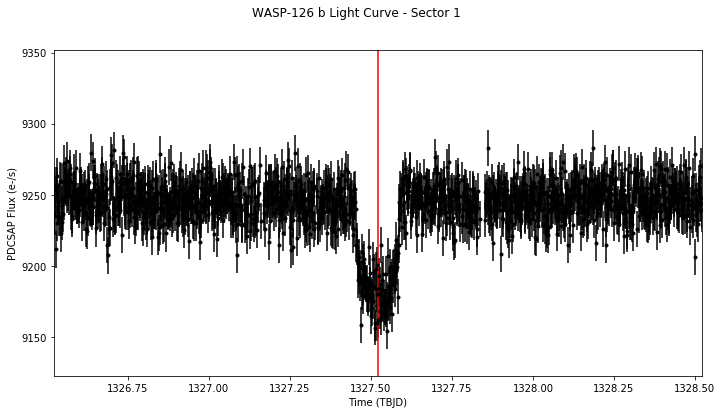

In [10]:
# Define the epoch of primary transit in TBJD.  Our timestamps are also already in TBJD.
t0 = 1327.520678

# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,6))

# Plot the timeseries in black circles.
ax.errorbar(tess_bjds, pdcsap_fluxes, pdcsap_fluxes_unc, fmt='.k')

# Center the x-axis on where we expect a transit to be (time = T0), and set
# the x-axis range within +/- 1 day of T0.
ax.set_xlim(t0 - 1.0, t0 + 1.0)

# Overplot a red vertical line that should be where the transit occurs.
ax.axvline(x=t0, color="red")

# Let's label the axes and define a title for the figure.
fig.suptitle("WASP-126 b Light Curve - Sector 1")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")

# Adjust the left margin so the y-axis label shows up.
plt.subplots_adjust(left=0.15)
plt.show()

## Understanding Light Curve Flags

The table of information contains more than just timestamps and fluxes.  In particular, there is a column of flags associated with every timestamp that indicate a number of warnings and conditions associated with that measurement.  Not every flag is worth excluding from your analysis: MAST has put together a summary of these flags with some suggestions on a good starting point for which flags to exclude [here](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview#id-2.0-DataProductOverview-Table:CadenceQualityFlags), but you should always make your own decision.  Let's make a plot of the light curve of WASP-126 b, but color-code any flag not set to 0.  *We emphasize that excluding all flags not set to 0 when analyzing the fluxes is **not** an optimal strategy, this is just for demonstration purposes.*

In [11]:
# First we need to read in the array of cadence quality flags, let's do
# that now.
with fits.open(fits_file, mode="readonly") as hdulist:
    qual_flags = hdulist[1].data['QUALITY']

In [12]:
qual_flags 

array([8, 0, 0, ..., 0, 0, 0], dtype=int32)

Now let's plot the full time series, but this time we'll overplot those points that have a quality flag greater than zero in red.

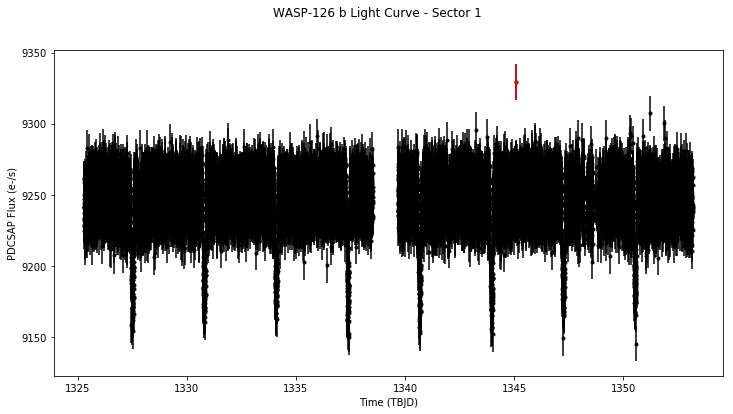

In [15]:
# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,6))

# Plot the timeseries in black circles.
ax.errorbar(tess_bjds, pdcsap_fluxes, pdcsap_fluxes_unc, fmt='.k', zorder=0)

# Locate quality flags greater than zero.
where_gt0 = np.where(qual_flags > 0)[0]

# Overplot the fluxes with quality flags greater than zero in red.
ax.errorbar(tess_bjds[where_gt0], pdcsap_fluxes[where_gt0], pdcsap_fluxes_unc[where_gt0], fmt='.r', zorder=1)

# Let's label the axes and define a title for the figure.
fig.suptitle("WASP-126 b Light Curve - Sector 1")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")
plt.show()

Indeed, almost all the fluxes with quality flags set to non-zero have NaN fluxes, and thus don't show up in our plot anyways.  Intringuingly, there is one measurement with a finite flux that does have one or more flags set.  It's one of the largest outliers in the positive flux direction: is this a bad measurement that should be excised from the time series?  Finding out the quality flag value and converting the value to its consitutent bit masks to understand why this point was flagged would be the first step.  We encourage you to do this as a follow-up to this tutorial.

In [20]:
ix = (qual_flags >0) & (~np.isnan(pdcsap_fluxes))
qual_flags[ix]

array([512], dtype=int32)

In [24]:
np.binary_repr(512)

'1000000000'

In [25]:
# Impulsive outlier removed before cotrending

## Displaying The Aperture Pixel Information

Let's read in the second FITS extension HDU to display the aperture information.  First, let's read in the aperture pixels from the HDU.

In [22]:
with fits.open(fits_file, mode="readonly") as hdulist:
    aperture = hdulist[2].data

Let's plot the pixels as an image.

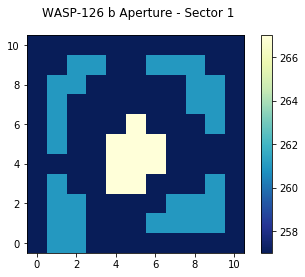

In [23]:
# Start figure and axis.
fig, ax = plt.subplots()

# Display the pixels as an image.
cax = ax.imshow(aperture, cmap=plt.cm.YlGnBu_r, origin="lower")

# Add a color bar.
cbar = fig.colorbar(cax)

# Add a title to the plot.
fig.suptitle("WASP-126 b Aperture - Sector 1")
plt.show()

## Understanding The Aperture Pixel Values

We see the pixel values are integers, but what do they mean?  The pixels are bitmasks that encode information about each pixel.  You can find a summary of what the different values mean [here](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview#id-2.0-DataProductOverview-Table:ApertureMaskImageFlags).  For example, a pixel in the aperture that might have a value of 57 can be broken down into power of 2 like: 32+16+8+1 = 57.  Referencing the table of values, this means this particular pixel was in CCD Output A, was used to calculate the Pixel Response Function (PRF) centroid, was used to calculate the flux weighted centroid, and was collected by the spacecraft.  Numpy has a bulit-in function that can convert an integer into a binary bit mask.  Let's use that now for one of the common values we see in our displayed image above.

In [26]:
# Break down a pixel value of 267 (yellow pixels displayed above) into its
# constituent bits.
bitmask = np.binary_repr(267)
print(bitmask)

100001011


Binary bits start from the right and end at the left, so the bit farthest on the right is the Least Significant Bit (LSB, equal to 2^0 = 1), the second from the right is 2^1=2, the third from the right is 2^2=4, etc.  This bit mask has bit values of 1 (2^0), 2 (2^1), 8 (2^3), and 256 (2^8) set.  From our look-up table, these values mean the pixels have been: collected by the spacecraft (value = 1), used in the optimal photometric aperture (value = 2), used to calculate the flux-weighted centroid (value = 8), and are on CCD Output D (value = 256).

## About this Notebook

**Author:** Scott W. Fleming, STScI Archive Scientist

**Updated On:** 2018-11-21

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 